# Titanic

![Titanic](Titanic.png)

In [1]:
# importing the libraries
import numpy as np
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('ggplot')

In [2]:
# Read CSV data into DataFrame
train_df = pd.read_csv("train.csv", index_col = 'PassengerId')
test_df = pd.read_csv("test.csv", index_col = 'PassengerId')

# Preview train data
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Sprawdzenie rozmiaru danych treningowych oraz testowych.
print(train_df.shape)
print(test_df.shape)

(891, 11)
(418, 10)


Uwaga:
W danych testowych nie ma zmiennej docelowej (tj. Brakuje kolumny "Survival"), więc naszym celem jest przewidzenie wartości tej zmiennej za pomocą różnych algorytmów uczenia maszynowego, np. regresji logistycznej.

### Poznawanie danych

Oznaczenia kolumn:
- Survived - Oznaczenie czy dana osoba przeżyła (1 - Tak, 0 - Nie)
- Pclass - Klasa przejazdu (1, 2, 3)
- Sex - Płeć (Male/Female)
- Age - Wiek
- SibSp - Ilość rodzeństwa/małżonków na pokładzie
- Parch - Ilość rodziców/dzieci na pokładzie
- Ticket - Numer biletu
- Fare - Opłata za rejs
- Cabin - Numer kabiny na pokładzie
- Embarked - Port zaokrętowania (C - Cherbourg, Q - Queenstown, S - Southampton)

![Route](TitanicRoute.png)

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Obserwacje:
- Brakuje części danych w kolumnie 'Age'
- Brakuje bardzo dużej ilości danych w kolumnie 'Cabin'
- Brakuje 2 rekordów danych w kolumnie 'Embarked'

Przyjrzyjmy się bliżej naszym danym

##### Age

In [5]:
# percent of missing "Age" 
print((train_df['Age'].isnull().sum()/train_df.shape[0])*100)

19.8653198653


W naszej kolumnie brakuje ok. 20% wpisów dotyczących wieku pasażera. Zobaczmy dokładniej, jak wygląda zmienna "Age".

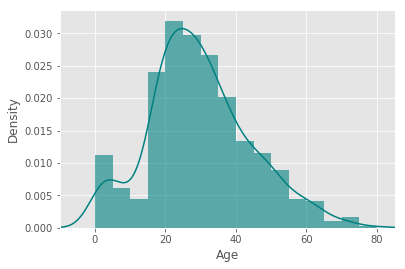

The mean of "Age" is 29.70
The median of "Age" is 28.00


In [6]:
ax = train_df["Age"].hist(bins = np.arange(0, 85, 5), density = True, stacked = True, color='teal', alpha=0.6)
train_df["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

# mean age
print('The mean of "Age" is %.2f' %(train_df["Age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(train_df["Age"].median(skipna=True)))

Ponieważ rozkład "Age" jest prawoskośny, użycie średniej może dać nam stronnicze wyniki, wypełniając Age starsze niż pożądane. Aby poradzić sobie z tym, użyjemy mediany do przypisania brakujących wartości. Zwróćmy uwagę także, że możemy wydzielić dwie grupy wśród naszej społeczności - dzieci (osoby poniżej 16 roku życia) oraz dorosłych.

##### Cabin

In [7]:
# percent of missing "Cabin" 
print((train_df['Cabin'].isnull().sum()/train_df.shape[0])*100)

77.1043771044


Ponieważ brakuje większości danych w kolumnie 'Cabin', to pominiemy ją podczas tworzenia naszego modelu.

##### Embarked

In [8]:
# percent of missing "Embarked" 
print((train_df['Embarked'].isnull().sum()/train_df.shape[0])*100)

0.224466891134


Ponieważ dla kolumny "Embarked" brakuje wartości tylko w dwóch rekordach danych, to w tym wypadku uzupełnimy je przez najczęściej występujących w danych port. Sprawdźmy zatem, z którego portu najczęściej odpływali ludzie.

S    644
C    168
Q     77
Name: Embarked, dtype: int64


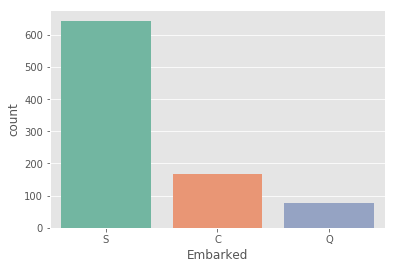

In [9]:
print(train_df['Embarked'].value_counts())
sns.countplot(x='Embarked', data=train_df, palette='Set2')
plt.show()

Z wykresu oraz tabelki danych widzimy, że najpopularniejszym portem był Southampton.

### Uzupełnianie danych

Na podstawie powyższej analizy w następujący sposób uzupełnimy nasze dane:

- Jeśli w danym wierszu brakuje wartości w kolumnie "Age", to przypiszemy mu wartość 28 (średni wiek).
- Jeśli w danym wierszu brakuje wartości w kolumnie "Embarked", to przypiszemy mu wartość "S" (najczęstszy port wejścia na pokład).
- Zignorujemy kolumnę "Cabin". Brakuje w niej zbyt wiele wartości, aby ta kolumna pozwoliła nam uzyskać dodatkowe informacje do modelu. W oparciu o dostępną wiedzę, okazuje się, że wartość ta jest związana z klasą pasażera i zapłaconą taryfą.

In [10]:
train_data = train_df.copy()
train_data["Age"].fillna(train_df["Age"].median(skipna = True), inplace = True)
train_data["Embarked"].fillna(train_df['Embarked'].value_counts().idxmax(), inplace = True)
train_data.drop('Cabin', axis = 1, inplace = True)

In [11]:
# Sprawdzamy, czy usunęliśmy wszystkie brakujące wartości w danych
train_data.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

### Data Engineering

Według dokumentacji załączonej na Kaggle kolumna 'SibSp' oraz 'Parch' odnoszą się do podróżowania z rodziną. Dla uproszczenia naszej analizy połączymy wpływ tych zmiennych w jedną zmienną kategoryczną 'TravelAlone', która będzie oznaczać czy dana osoba podróżuje samotnie. Ponadto zauważyliśmy w trakcie eksploracji danych, że społeczność znajdująca się na statku może zostać podzielona na dwie grupy - dzieci, dorośli. W celu uwzględnienia tego podziału stworzymy zmienną IsMinor, która będzie oznaczać czy dana osoba ma mniej niż 16 lat.

In [12]:
# Tworzenie zmiennej kategorycznej dla osób, które podróżują same
train_data['TravelAlone'] = np.where((train_data["SibSp"]+train_data["Parch"])== 0, 1, 0) #Warunek, True, False
train_data.drop(['SibSp', 'Parch'], axis=1, inplace=True)

train_data['IsMinor'] = np.where(train_data['Age'] <= 16, 1, 0)

In [13]:
train_data.head()

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,TravelAlone,IsMinor
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,A/5 21171,7.2500,S,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,PC 17599,71.2833,C,0,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,STON/O2. 3101282,7.9250,S,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,113803,53.1000,S,0,0
5,0,3,"Allen, Mr. William Henry",male,35.0,373450,8.0500,S,1,0


### Data Preprocessing

Algorytmy uczenia maszynowego są zaprogramowane w ten sposób, że jako wejście przyjmują jedynie macierze danych w postaci liczb. Ponieważ nasze dane zawierają kolumny, które nie zawierają danych numerycznych, to musimy zmienić sposób ich reprezentacji na numeryczny. Aby dokonać tej zamiany poznamy dwie metody: Label Encoding oraz One Hot Encoding, a następnie wykorzystując jedną z nich.

####  Label Encoding vs One Hot Encoding

![LB vs OHE](LabelVSOneHot.jpg)

In [14]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder

print(train_data['Sex'].head())
print('-'*30)

le = LabelEncoder()
train_data['Sex'] = le.fit_transform(train_data['Sex'])

print(train_data['Sex'].head())

PassengerId
1      male
2    female
3    female
4    female
5      male
Name: Sex, dtype: object
------------------------------
PassengerId
1    1
2    0
3    0
4    0
5    1
Name: Sex, dtype: int64


In [15]:
from IPython.display import display #Ładne printowanie dwóch tabel w 1 komórce

display(train_data.head())

# One Hot Encoding
training = pd.get_dummies(train_data, columns=["Pclass","Embarked"], drop_first = True)
# Usuwanie zbędnych kolumn
training.drop(['Name', 'Ticket'], axis = 1, inplace = True)

final_train = training
display(final_train.head())

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,TravelAlone,IsMinor
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,S,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,C,0,0
3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,S,1,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,S,0,0
5,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,S,1,0


,Survived,Sex,Age,Fare,TravelAlone,IsMinor,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,1,22.0,7.2500,0,0,0,1,0,1
2,1,0,38.0,71.2833,0,0,0,0,0,0
3,1,0,26.0,7.9250,1,0,0,1,0,1
4,1,0,35.0,53.1000,0,0,0,0,0,1
5,0,1,35.0,8.0500,1,0,0,1,0,1


Teraz zastosujemy te same zmiany w danych testowych. Dla wieku przypiszemy średnią równą 28. Zignorujemy Kabinę. Dla zmiennej "Emabrked" nic nie musimy robić.

In [16]:
test_df.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [17]:
test_data = test_df.copy()

#Uzupełnianie danych
test_data["Age"].fillna(train_df["Age"].median(skipna = True), inplace = True)
test_data["Fare"].fillna(train_df["Fare"].median(skipna = True), inplace = True)
test_data.drop('Cabin', axis = 1, inplace = True)

#Tworzenie nowych zmiennych
test_data['TravelAlone'] = np.where((test_data["SibSp"] + test_data["Parch"])== 0, 1, 0)
test_data['IsMinor']  =np.where(test_data['Age'] <= 16, 1, 0)

#Usuwanie niepotrzebnych zmiennych
test_data.drop(['SibSp', 'Parch', 'Name', 'Ticket'], axis = 1, inplace = True)

#Label Encoding and One Hot Encoding
test_data['Sex'] = le.transform(test_data['Sex'])
testing = pd.get_dummies(test_data, columns = ["Pclass","Embarked"], drop_first = True)

final_test = testing
final_test.head()

,Sex,Age,Fare,TravelAlone,IsMinor,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
892,1,34.5,7.8292,1,0,0,1,1,0
893,0,47.0,7.0000,0,0,0,1,0,1
894,1,62.0,9.6875,1,0,1,0,1,0
895,1,27.0,8.6625,1,0,0,1,0,1
896,0,22.0,12.2875,0,0,0,1,0,1


Mając przygotowane dane przystępujemy do części uczenia naszego modelu, którym w tym wypadku będzie regresja logistyczna.

## Ćwiczenia (ok. 15 minut)

Poniżej znajdują się załadowane dane dot. zmiany masy mammograficznej z BI-RADS oraz wieku pacjenta. Oryginalny opis znajduje się poniżej:

> This data set can be used to predict the severity (benign or malignant) of a mammographic mass lesion from BI-RADS attributes and the patient's age.

> It contains a BI-RADS assessment, the patient's age and three BI-RADS attributes together with the ground truth (the severity field, which is the target attribute).

> The data was collected at the Institute of Radiology of the University Erlangen-Nuremberg between 2003 and 2006.

> Źródło: https://sci2s.ugr.es/keel/dataset.php?cod=86

Naszym celem jest przewidzenie wartości w kolumnie 'Severity', która oznacza złośliwość raka (Malignant - złośliwy, Benign - łagodny). Wykorzystując wcześniej poznane techniki uzupełnij brakujące dane oraz dokonaj przygotowania danych do modelowania (Podpowiedź: Kolumna 'Severity')

In [120]:
df = pd.read_csv('Mammographic.csv')
df.head()

,BI-RADS,Age,Shape,Margin,Density,Severity
0,5.0,67.0,3.0,5.0,3.0,Malignant
1,4.0,43.0,1.0,1.0,NaN,Malignant
2,5.0,58.0,4.0,5.0,3.0,Malignant
3,4.0,28.0,1.0,1.0,3.0,Benign
4,5.0,74.0,1.0,5.0,NaN,Malignant


In [122]:
# Your code goes here :)

## Logistic Regression

![Logistic Regression](Logistic1.PNG)

![Logistic Regression](Logistic2.PNG)

![Logistic Regression](Logistic3.PNG)

![Logistic Regression](Logistic4.PNG)

![Logistic Regression](Logistic5.PNG)

![Logistic Regression](Logistic6.PNG)

![Logistic Regression](Logistic7.PNG)

![Logistic Regression](Logistic8.PNG)

In [18]:
final_train.head()

,Survived,Sex,Age,Fare,TravelAlone,IsMinor,Pclass_2,Pclass_3,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,1,22.0,7.2500,0,0,0,1,0,1
2,1,0,38.0,71.2833,0,0,0,0,0,0
3,1,0,26.0,7.9250,1,0,0,1,0,1
4,1,0,35.0,53.1000,0,0,0,0,0,1
5,0,1,35.0,8.0500,1,0,0,1,0,1


In [19]:
#Podział danych na dane testowe oraz treningowe
from sklearn.model_selection import train_test_split

X = final_train.drop('Survived', axis = 1)
y = final_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.794776119403


##### Confusion Matrix

![Confusion Matrix](ConfMatrix.png)

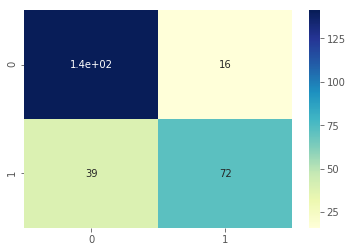

In [21]:
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, cmap = "YlGnBu")
plt.show()

##### ROC, AUC

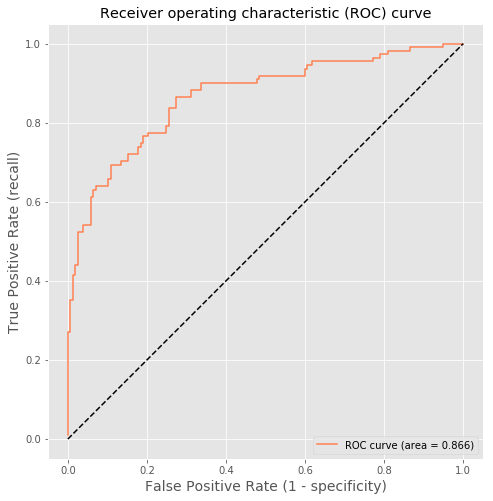

In [50]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

plt.figure(figsize = (8,8))
plt.plot(fpr, tpr, color = 'coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.axis('square')
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc = "lower right")
plt.show()

Przykład implementacji lasu losowego na tych samych danych:

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:,1]

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('AUC: ', auc(fpr, tpr))

Accuracy:  0.776119402985
AUC:  0.866414184886


## Ćwiczenia (ok. 10 minut)

- Na podstawie wcześniej przygotowanych danych dopasuj model regresji liniowej
- Zbadaj skuteczność swojego modelu za pomocą poznanych technik
- Wykonaj powyższe ćwiczenia wykorzystując inny model uczenia maszynowego (np. DecisionTreeClassifier(sklearn.ensemble), RandomForestClassifier(sklearn.ensemble), ExtraTreesClassifier(sklearn.ensemble), GaussianNB (sklearn.naive_bayes), SVC(sklearn.svm))
- Zadanie dodatkowe: Zbadaj skuteczność swojego modelu za pomocą cross-validation (pierwsza część warsztatów)

In [121]:
# Your code goes here :)

## Podsumowanie

Podczas tej części warsztatów zostały poruszone następujące tematy:

- Podstawowe metody radzenia sobie z brakującymi danymi
- Inżynieria danych, czyli tworzenie nowych zmiennych do modelu
- Przygotowanie danych, czyli kodowanie danych tak, aby komputer potrafił nas zrozumieć
- Zasada działania regresji liniowej
- Metody oceny skuteczności modelu

Dla ciekawskich więcej zbiorów danych można znaleźć tutaj:
http://scikit-learn.org/stable/datasets/index.html (Rozdział 5.2)

# Dziękujemy za uwagę!

Dziękujemy serdecznie za uwagę podczas warsztatów. Mamy nadzieję, że udało Nam się zainteresować Cię tematyką analityki oraz uczenia maszynowego. Po tych zajęciach nie powinny być już Tobie straszne brakujące dane, stringi w ramkach danych, a tworzenie modeli uczenia maszynowego powinno być jak bułka z masłem :) 

Jeżeli chcesz dalej zagłębiać się w tematy analityczne, uczenie maszynowe, bądź statystykę, to serdecznie zapraszamy na Gaussową akcję-rekrutację nowych członków. Więcej informacji pod linkiem:

https://www.facebook.com/events/358017688277706/

Ponadto zapraszamy na naszego facebook'a, gdzie znajdziecie więcej informacji o kole:

https://www.facebook.com/gausspwr/

Warsztaty przeprowadzili członkowie Koła Naukowego Statystyki Matematycznej "Gauss":

- Patrycja Kowalek
- Patryk Wielopolski

![gauss](gauss.png)